In [1]:
import pandas as pd
import numpy as np
import math, sys
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
df = pd.read_csv('Datasets/preprocessed-dataset/preproc_classification_data.csv')
df.head()

,End_Time,Region,Site,Average_volume_of_all_detectors,precipitation_amount_(mm),air_temperature_(C),classification_output
0,1/1/2020 1:00,CCITY,1,9,0.0,6.9,-1
1,1/1/2020 1:00,CCITY,2,174,0.0,6.9,1
2,1/1/2020 1:00,CCITY,3,39,0.0,6.9,1
3,1/1/2020 1:00,CCITY,17,8,0.0,6.9,-1
4,1/1/2020 1:00,CCITY,19,21,0.0,6.9,1


In [3]:
df_site_info = pd.read_csv('Datasets/traffic_volumes_site_metadata_jan_jun_2020/its_scats_sites_aug-2020.csv')
CITY_CENTER = df_site_info.Region == "CCITY"
df_site_info = df_site_info[CITY_CENTER]

In [4]:
#Train models for these sites and evaluate
# High Traffic Volume Sites: 628,305,2
# Medium Traffic Sites: 48,36,420,3
# Low Traffic Sites : 796, 1,402, 665
SITES_LIST = [628,305,2,48,36,420,3,796, 1,402,665]
sites_df_dict = {}
sites_df_list = list()
for count, site in enumerate(SITES_LIST):
    site_id = df.Site == site
    df_site = df[site_id]
    sites_df_dict[count] = df_site
    sites_df_list.append(df_site)

SITE_1 = df.Site == 1
df_site_1 = df[SITE_1]

In [15]:
# convert date/time to unix timestamp in sec
all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000
time_sampling_interval = all_timestamps_in_sec[1] - all_timestamps_in_sec[0]
print("data sampling interval is %d secs"%time_sampling_interval)

data sampling interval is 3600 secs


C:\Users\adish\AppData\Local\Temp/ipykernel_3468/1260594523.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000


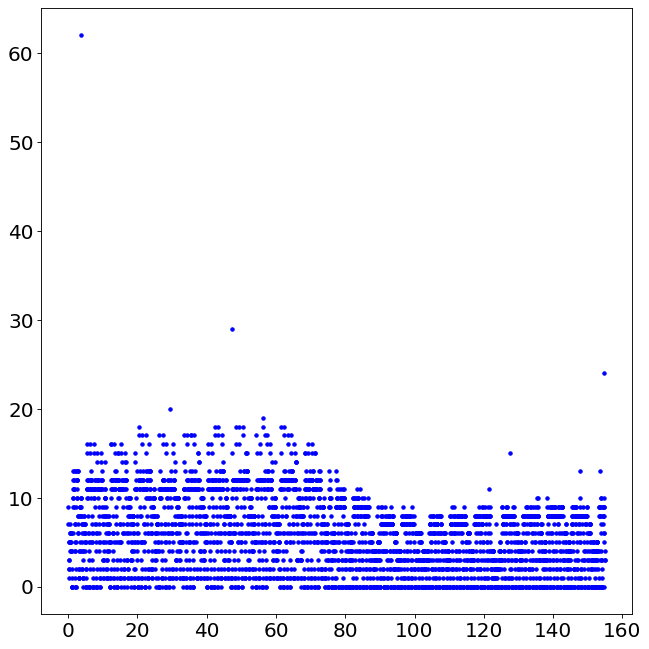

In [16]:
timestamps_in_days=(all_timestamps_in_sec-all_timestamps_in_sec[0])/60/60/24 # convert timestamp to days
y_output_avg_vol_cars = np.extract(all_timestamps_in_sec,df_site_1.iloc[:,3]).astype(np.int64)
y_output_precipitation = np.extract(all_timestamps_in_sec,df_site_1.iloc[:,4]).astype(np.int64)
y_output_classification = np.extract(all_timestamps_in_sec,df_site_1.iloc[:,6]).astype(np.int64)

# plot extracted data
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(timestamps_in_days,y_output_avg_vol_cars, color='blue', marker='.'); plt.show()

In [17]:
#dd is trend or seasonality
#lag is number of points
#q is step size
def test_preds(q,dd,lag, plot):
    #q-step ahead prediction
    stride=1
    X=y_output_avg_vol_cars[0:y_output_avg_vol_cars.size-q-lag*dd:stride]
    X_weather=y_output_precipitation[0:y_output_avg_vol_cars.size-q-lag*dd:stride]
    XX=np.column_stack((X,X_weather))
    for i in range(1,lag):
        X=y_output_avg_vol_cars[i* dd:y_output_avg_vol_cars.size-q- (lag-i)*dd:stride]
        X_weather = y_output_precipitation[i* dd:y_output_avg_vol_cars.size-q- (lag-i)*dd:stride]
        XX=np.column_stack((XX,X,X_weather))
    yy=y_output_avg_vol_cars[lag* dd+q::stride]
    end_time_in_days=timestamps_in_days[lag* dd+q::stride]
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    from sklearn.linear_model import Ridge
    # from sklearn.neighbors import KNeighborsRegressor
    # model = KNeighborsRegressor(n_neighbors =10).fit(XX[train], yy[train])
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
        y_pred = model.predict(XX)
        plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(end_time_in_days, y_pred, color='blue')
        plt.xlabel("time (days)"); plt.ylabel("#volume of cars")
        plt.legend(["training data","predictions"],loc='upper right')
        day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
        plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
        plt.show()

0.0 [0.24886996 0.54337176 0.05166435 0.65713466 0.27021018 0.80745584]


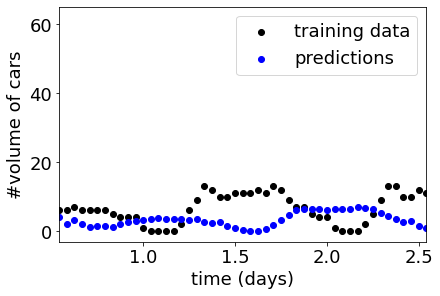

0.0 [0.31707054 0.51266251 0.22537948 0.48246065 0.376482   0.45738831]


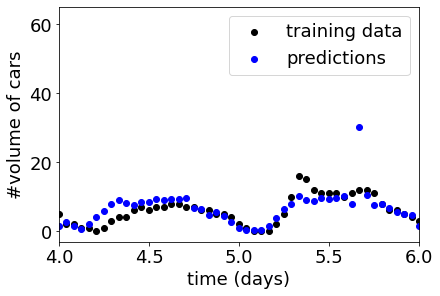

0.0 [ 0.02819869 -0.05610934  0.25496498  0.06566657  0.61392782 -0.10304869]


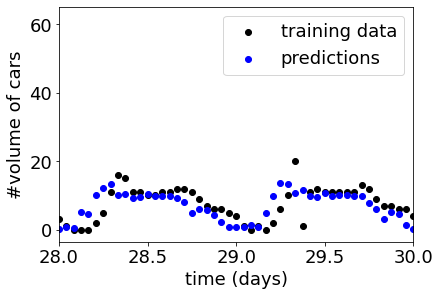

In [18]:
# prediction using short-term trend
plot=True
test_preds(q=10,dd=1,lag=3,plot=plot)

# # prediction using daily seasonality
d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
test_preds(q=d,dd=d,lag=3,plot=plot)

# # # prediction using weekly seasonality
w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
test_preds(q=w,dd=w,lag=3,plot=plot)

0.0 [ 0.00386393 -0.01661119  0.24884185 -0.07326092  0.54717199 -0.14521625
  0.00386393 -0.01661119  0.02391199 -0.16917915  0.02227736 -0.12932038
 -0.02711388 -0.19855826 -0.00237185 -0.00549576  0.10958375 -0.11413035]


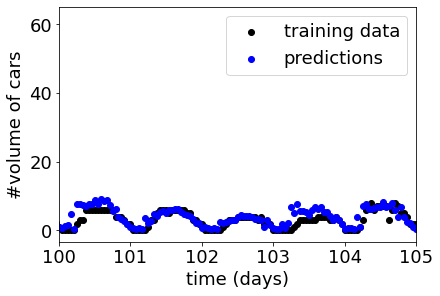

In [19]:
#putting it together
q=10
lag=3; stride=1
w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
len = y_output_avg_vol_cars.size-w-lag*w-q

X = y_output_avg_vol_cars[q:q+len:stride]
X_weather = y_output_precipitation[q:q+len:stride]
XX=np.column_stack((X,X_weather))
for i in range(1,lag):
    X=y_output_avg_vol_cars[i*w+q:i*w+q+len:stride]
    X_weather=y_output_precipitation[i*w+q:i*w+q+len:stride]
    XX=np.column_stack((XX,X, X_weather))
for i in range(0,lag):
    X=y_output_avg_vol_cars[i*d+q:i*d+q+len:stride]
    X_weather=y_output_precipitation[i*d+q:i*d+q+len:stride]
    XX=np.column_stack((XX,X, X_weather))
for i in range(0,lag):
    X=y_output_avg_vol_cars[i:i+len:stride]
    X_weather=y_output_precipitation[i:i+len:stride]
    XX=np.column_stack((XX,X, X_weather))

yy=y_output_avg_vol_cars[lag*w+w+q:lag*w+w+q+len:stride]
yy_output_classification = y_output_classification[lag*w+w+q:lag*w+w+q+len:stride]

end_time_in_days=timestamps_in_days[lag*w+w+q:lag*w+w+q+len:stride]
from sklearn.model_selection import train_test_split
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
from sklearn.linear_model import Ridge
model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
print(model.intercept_, model.coef_)
# from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor(n_neighbors =10).fit(XX[train], yy[train])

train_classification, test_classification = train_test_split(np.arange(0,yy_output_classification.size),test_size=0.2)
from sklearn.linear_model import LogisticRegression
model_classification = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1, max_iter=10000)
model_classification.fit(XX[train_classification], yy[train_classification])
y_pred = model_classification.predict(XX)

if plot:
    y_pred = model.predict(XX)
    plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(end_time_in_days, y_pred, color='blue')
    plt.xlabel("time (days)"); plt.ylabel("#volume of cars")
    plt.legend(["training data","predictions"],loc='upper right')
    day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
    plt.xlim((10*10,10*10+5))
    plt.show()


In [10]:
# TODO:
# Cross-Validation -kFold or timeseries split
# Using sites as features
# Different Model implementations
# Using weather features
# Include Collab Plots
# Evaluation
# Report

In [11]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score  # Spot Check Algorithms

models = []()
models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor()))
# models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []

for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    # neg_mean_squared_error_scorer = make_scorer(mean_squared_error,greater_is_better=False)
    cv_results = cross_val_score(model, XX, yy, cv=tscv, scoring="neg_mean_squared_error")
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

<>:6: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
C:\Users\adish\AppData\Local\Temp/ipykernel_3468/3326118895.py:6: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
  models = []()


TypeError: 'list' object is not callable

In [ ]:
import sklearn

sorted(sklearn.metrics.SCORERS.keys())